In [1]:
!git clone https://github.com/anoopkunchukuttan/indic_nlp_resources.git -q
!git clone https://github.com/anoopkunchukuttan/indic_nlp_library.git -q


In [1]:
import sys
# The path to the local git repo for Indic NLP library
INDIC_NLP_LIB_HOME=r"./indic_nlp_library"
# The path to the local git repo for Indic NLP Resources
INDIC_NLP_RESOURCES=r"./indic_nlp_resources"
sys.path.append(r'{}'.format(INDIC_NLP_LIB_HOME))
from indicnlp import common
common.set_resources_path(INDIC_NLP_RESOURCES)
from indicnlp import loader
loader.load()

In [100]:
from indicnlp.transliterate.unicode_transliterate import ItransTransliterator
from indicnlp.tokenize import indic_tokenize  
import numpy as np
from numpy import argmax
import re
import csv
import numpy as np
import pandas as pd
global alphabet
global maxlen
global N_LANG
global languages
N_LANG=10
maxlen=28
alphabet = "abcdefghijklmnopqrstuvwxyz"
languages=["hi","bn","gu","kn","mr","or","ta","te","ml","pa"]
languages.sort()

In [5]:

def one_hot_encode(data):
  char_to_int = dict((c, i) for i, c in enumerate(alphabet))
  integer_encoded = [char_to_int[char] for char in data]
  onehot_encoded = []
  
  for value in integer_encoded:
    letter = np.zeros(len(alphabet))
    letter[value] = 1
    onehot_encoded.append(letter)
  while(len(onehot_encoded)<maxlen):
    letter = np.zeros(len(alphabet))
    onehot_encoded.append(letter)
  return  np.array(onehot_encoded)


    
def process(test_str):
  test_str=test_str.lower()
  test_str = re.sub(r'[^a-zA-Z ]', '', test_str)
  rem=['\u0964','\u0965','']
  test_str = re.sub(r'', '', test_str)
  return test_str

def encode_labels(label):
  temp = np.zeros(N_LANG)
  temp[label-1] = 1
  return temp

def encode_labels_indic(label):
    temp = np.zeros(N_LANG)
    i=languages.index(label)
    temp[i] = 1
    return temp


def invert_one_hot_encode(data):
  int_to_char = dict((i, c) for i, c in enumerate(alphabet))
  inverted=""
  for ch in data:
    inverted+= int_to_char[argmax(ch)]

In [47]:
df=pd.read_csv('./words.csv')

In [48]:
X=[]
Y=[]
counts=[]
for word,lang in zip(df.words,df.lang):
  if(pd.isna(word)):
      continue
  #counts.append(lang)
  word=process(ItransTransliterator.to_itrans(word,lang))
  if(len(word)<=maxlen and word not in ['',' ']):   
      X.append(one_hot_encode(process(ItransTransliterator.to_itrans(word,lang))))
      Y.append(encode_labels_indic(lang))
del df
X=np.array(X)
Y=np.array(Y)

In [7]:

X=np.reshape(X,(X.shape[0],X.shape[1]*X.shape[2]))
X.shape




(99972, 728)

In [44]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Flatten
from keras.callbacks import ModelCheckpoint, TensorBoard

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)


In [42]:
network.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 600)               437400    
_________________________________________________________________
dense_7 (Dense)              (None, 400)               240400    
_________________________________________________________________
dense_8 (Dense)              (None, 200)               80200     
_________________________________________________________________
dense_9 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1010      
Total params: 779,110
Trainable params: 779,110
Non-trainable params: 0
_________________________________________________________________


network = Sequential()
network.add(Flatten())
network.add(Dense(600, input_dim=26*maxlen, activation='sigmoid'))
network.add(Dense(400, activation='sigmoid'))
network.add(Dense(200, activation='sigmoid'))
network.add(Dense(100, activation='sigmoid'))
network.add(Dense(N_LANG, activation='softmax'))

network.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [51]:
network = Sequential()
network.add(Flatten())
network.add(Dense(600, input_dim=26*maxlen, activation='sigmoid'))
network.add(Dense(400, activation='sigmoid'))
network.add(Dense(200, activation='sigmoid'))
network.add(Dense(100, activation='sigmoid'))
network.add(Dense(N_LANG, activation='softmax'))

network.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [52]:
filepath = "./weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
tboard = TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
callbacks_list = [checkpoint, tboard]

history=network.fit(X_train, y_train, epochs=20, batch_size=256, validation_data=(X_test, y_test), callbacks=callbacks_list,verbose=1)

Train on 66981 samples, validate on 32991 samples
Epoch 1/20
66981/66981 [==============================] - 3s 42us/step - loss: 0.3200 - accuracy: 0.9000 - val_loss: 0.2971 - val_accuracy: 0.9000
Epoch 2/20
 5120/66981 [=>............................] - ETA: 2s - loss: 0.2962 - accuracy: 0.9000

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


66981/66981 [==============================] - 3s 38us/step - loss: 0.2846 - accuracy: 0.9014 - val_loss: 0.2775 - val_accuracy: 0.9026
Epoch 3/20
66981/66981 [==============================] - 3s 38us/step - loss: 0.2720 - accuracy: 0.9035 - val_loss: 0.2698 - val_accuracy: 0.9041
Epoch 4/20
66981/66981 [==============================] - 3s 38us/step - loss: 0.2627 - accuracy: 0.9058 - val_loss: 0.2590 - val_accuracy: 0.9063
Epoch 5/20
66981/66981 [==============================] - 3s 38us/step - loss: 0.2549 - accuracy: 0.9075 - val_loss: 0.2544 - val_accuracy: 0.9075
Epoch 6/20
66981/66981 [==============================] - 3s 39us/step - loss: 0.2487 - accuracy: 0.9093 - val_loss: 0.2494 - val_accuracy: 0.9086
Epoch 7/20
66981/66981 [==============================] - 3s 38us/step - loss: 0.2453 - accuracy: 0.9101 - val_loss: 0.2470 - val_accuracy: 0.9095
Epoch 8/20
66981/66981 [==============================] - 3s 38us/step - loss: 0.2422 - accuracy: 0.9112 - val_loss: 0.2432 - val

In [28]:
%load_ext tensorboard
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
!kill 22029
%tensorboard --logdir {logs_base_dir} --host=localhost  --port 6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [53]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

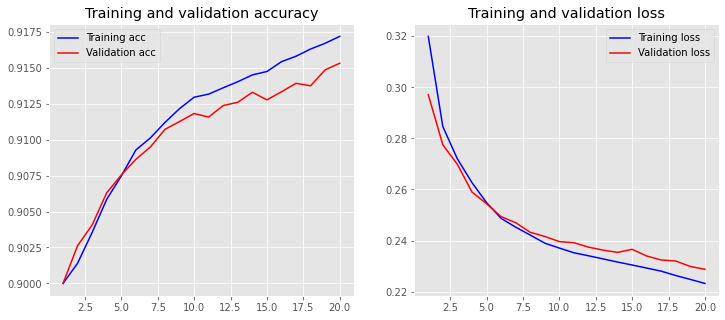

In [54]:


plot_history(history)



In [106]:
st='aamhi maanhus aaho'
x=[]
for word in st.split():
    print(word)
    x.append(one_hot_encode(process(word)))
    
ans=network.predict(np.array(x))
''''''
t=one_hot_encode(process(tokenize()))
s=encode_labels_indic('mr')
print(s)
print(t.shape,s.shape)
t=np.reshape(t,(1,t.shape[0],t.shape[1]))
s=np.reshape(s,(1,10))
print(t.shape,s.shape)
ans=network.predict(t)
''''''


aamhi
maanhus
aaho


"\nt=one_hot_encode(process(tokenize()))\ns=encode_labels_indic('mr')\nprint(s)\nprint(t.shape,s.shape)\nt=np.reshape(t,(1,t.shape[0],t.shape[1]))\ns=np.reshape(s,(1,10))\nprint(t.shape,s.shape)\nans=network.predict(t)\n"

In [107]:
print(ans)

[[0.07085986 0.15824607 0.15293309 0.07961413 0.01072838 0.15105116
  0.09204894 0.14782278 0.00994299 0.1267525 ]
 [0.02706261 0.17490156 0.05340629 0.27850556 0.10294501 0.0291759
  0.10498627 0.01801721 0.01656017 0.1944394 ]
 [0.06659287 0.26475072 0.18307742 0.02262179 0.02299095 0.08501463
  0.05452383 0.2748213  0.00708473 0.01852177]]


In [69]:
languages



['bn', 'gu', 'hi', 'kn', 'ml', 'mr', 'or', 'pa', 'ta', 'te']